# PROJET Apprentissage profond 

Auteur: Cassandra SEIVE & Alicia BOUCHER

# Partie 1

L'algorithme des plus proches voisins KNN fait partie des algorithmes de Machine Learning ou apprentissages automatiques les plus simples à utiliser. Ce type d'algorithme a pour principale fonction la recherche de similitude et la reconnaissance de formes en suivant la méthode non pragmatique d'estimation statistique. C'est un modèle d'apprentissage automatique supervisé dont voici le fonctionnement et quelques applications.

In [1]:
import os
#os.environ["CUDA_VISIBLE_DEVICES"]="-1"  #disables GPU 
import numpy as np
from sklearn.neighbors import NearestNeighbors
from scipy.ndimage import zoom
import matplotlib.pyplot as plt
import nibabel as nib

In [2]:
def load_keypoints(file_path):
    """
    Charge les points clés à partir d'un fichier texte.
    """
    with open(file_path, 'r') as file:
        lines = file.readlines()

    keypoints = []
    for line in lines:
        if not line.startswith("#") and not line.startswith("Features:"):
            try:
                # On récupère x, y, z, et scale (4 premières colonnes)
                values = [float(value) for value in line.split()]
                keypoints.append(values[:4])  # x, y, z, scale
            except ValueError:
                continue

    return np.array(keypoints)


def load_hdr_img(hdr_file_path, img_file_path):
    """
    Charge une image volumétrique en utilisant les fichiers .hdr et .img associés.
    """
    img = nib.load(img_file_path)  # Charger l'image avec nibabel
    img_data = img.get_fdata()  # Obtenir les données sous forme de tableau numpy

    # Vérifier si l'image a 4 dimensions (cas où la dernière dimension est de taille 1)
    if img_data.ndim == 4 and img_data.shape[-1] == 1:
        img_data = img_data.squeeze(axis=-1)  # Supprimer la dernière dimension

    return img_data  # Retourner les données sous forme de tableau numpy


def show_slice(image_data, slice_idx, cmap='gray'):
    """
    Affiche une tranche spécifique de l'image volumétrique.
    """
    plt.imshow(image_data[slice_idx, :, :], cmap=cmap)
    plt.title(f"Tranche {slice_idx}")
    plt.axis('off')
    plt.show()

# Exemple d'utilisation
img_file_path = r"C:\Users\alici\Desktop\Polytech\cours\ETS S1\IA\projet\key_img_hdr\OAS1_0011_MR1_mpr_nn_anon_111_t88_masked_gfc.img"


hdr_file_path = img_file_path.replace(".img", ".hdr")

# Charger l'image
img_data = load_hdr_img(hdr_file_path, img_file_path)

print(f"Dimensions après chargement : {img_data.shape}")

Dimensions après chargement : (176, 208, 176)


Chargement des images...


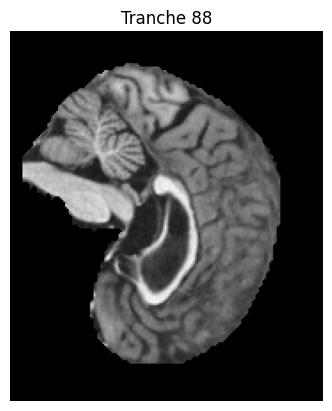

In [3]:
# Liste pour les images
database_imgs = []

# Paramètres principaux
key_folder = r"C:\Users\alici\Desktop\Polytech\cours\ETS S1\IA\projet\key_img_hdr"  # Dossier contenant les fichiers .hdr/.img/.key
#BIEN PENSER A CHANGER LE CHEMIN D'ACCES DES FICHIERS .HDR (NOUS ILS SONT DANS LE MEME DOSSIER "key_img_hdr")


# Parcourir le dossier pour charger les fichiers .hdr et .img associés
print("Chargement des images...")
for file in os.listdir(key_folder):
    if file.endswith(".hdr"):  # Charger uniquement les fichiers .hdr
        try:
            hdr_file_path = os.path.join(key_folder, file)
            img_file_path = hdr_file_path.replace('.hdr', '.img')  # Le fichier .img correspondant

            if os.path.exists(img_file_path):  # Vérifier si le fichier .img existe
                # Charger l'image à partir des fichiers .hdr et .img
                image_data = load_hdr_img(hdr_file_path, img_file_path)
                database_imgs.append(image_data)
            else:
                print(f"Le fichier .img associé est manquant pour {hdr_file_path}")
        except Exception as e:
            print(f"Erreur lors du traitement de {file}: {e}")

# Affichage d'une tranche médiane d'une image chargée (si des images ont été chargées)
if database_imgs:
    img_example = database_imgs[0]  # Choisir la première image parmi celles chargées

    # Afficher une tranche médiane de l'image 3D
    slice_idx = img_example.shape[0] // 2  # Utiliser la tranche médiane
    show_slice(img_example, slice_idx)
else:
    print("Aucune image trouvée dans le dossier.")


In [4]:
def normalize_volume(volume):
    """
    Normalise le volume pour qu'il soit compris entre 0 et 255.
    """
    volume = volume.astype(np.float64)  # Assurez-vous que le volume est en float64 pour éviter les erreurs de casting
    volume -= volume.min()  # Soustraire le minimum pour commencer à 0
    volume /= volume.max()  # Diviser par le maximum pour amener le maximum à 1
    volume *= 255  # Multiplier par 255 pour avoir une plage de [0, 255]
    
    return volume.astype(np.uint8)  # Convertir en uint8 pour le stockage ou l'affichage


In [5]:
def save_volume_as_img_and_mhd(volume, output_prefix, spacing=(1.0, 1.0, 1.0)):
    """
    Sauvegarde le volume sous forme de fichiers .img et .mhd.
    """
    img_file_path = f"{output_prefix}.img"
    volume.tofile(img_file_path)

    mhd_file_path = f"{output_prefix}.mhd"
    with open(mhd_file_path, 'w') as mhd_file:
        mhd_file.write("ObjectType = Image\n")
        mhd_file.write("NDims = 3\n")
        mhd_file.write(f"DimSize = {volume.shape[2]} {volume.shape[1]} {volume.shape[0]}\n")
        mhd_file.write("ElementType = MET_UCHAR\n")
        mhd_file.write(f"ElementSpacing = {spacing[0]} {spacing[1]} {spacing[2]}\n")
        mhd_file.write(f"ElementDataFile = {os.path.basename(img_file_path)}\n")

In [6]:
def visualize_slices(volume, num_slices=5):
    """
    Visualise quelques coupes d'un volume 3D.
    """
    slices = np.linspace(0, volume.shape[0] - 1, num_slices, dtype=int)
    plt.figure(figsize=(15, 5))
    for i, slice_idx in enumerate(slices):
        plt.subplot(1, num_slices, i + 1)
        plt.imshow(volume[slice_idx], cmap='gray')
        plt.axis('off')
        plt.title(f"Slice {slice_idx}")
    plt.tight_layout()
    plt.show()

In [7]:
def test_shapes(file_path, shapes, cmap='gray'):
    """
    Teste plusieurs formes pour trouver celle qui correspond correctement,
    sans redimensionner ou réarranger les données.
    """
    # Lire les données brutes
    data = np.fromfile(file_path, dtype=np.uint8)
    
    # Vérification de la taille totale des données
    data_size = len(data)

    for shape in shapes:
        try:
            print(f"Test de la forme {shape}")
            expected_size = np.prod(shape)

            # Vérification de la taille des données
            if data_size != expected_size:
                print(f"Taille incorrecte pour la forme {shape}. Taille attendue: {expected_size}, taille des données: {data_size}")
                continue

            # Si les tailles correspondent, on reformate les données en 3D
            volume = data.reshape(shape)

            # Choisir un colormap adapté (on peut utiliser 'inferno' ou 'gray' pour des contrastes mieux visibles)
            volume = volume.astype(np.float32)  # Utiliser float32 pour éviter de tronquer les valeurs
            volume -= volume.min()  # Centrer autour de 0
            volume /= volume.max()  # Normaliser pour que les valeurs soient dans l'intervalle [0, 1]

            # Affichage d'une tranche spécifique au centre du volume
            middle_slice = volume[shape[0] // 2, :, :]  # Tranche au milieu
            plt.figure(figsize=(6, 6), dpi=300)  # Augmenter le DPI pour plus de netteté
            plt.imshow(middle_slice, cmap=cmap, interpolation='none', aspect='auto')
            plt.title(f"Middle Slice {shape[0] // 2}")
            plt.axis('off')  # Supprime les axes
            plt.show()

        except Exception as e:
            print(f"Erreur avec la forme {shape}: {e}")

# Liste des formes plausibles (exemples)
possible_shapes = [
    (176, 208, 176),  # Forme cible, à ajuster selon le format de l'image
]

# Parcourir le dossier pour charger les fichiers .hdr et .img
key_folder = r"C:\Users\alici\Desktop\Polytech\cours\ETS S1\IA\projet\key_img_hdr"  # Dossier contenant les fichiers .hdr, .key et .img
#BIEN PENSER A CHANGER LE CHEMIN D'ACCES DES FICHIERS .HDR ET .IMG (NOUS ILS SONT DANS LE MEME DOSSIER "key_img_hdr")

# Tester les fichiers .hdr et .img
print("Chargement et test des fichiers .hdr et .img...")
for file in os.listdir(key_folder):
    if file.endswith(".hdr"):  # Charger uniquement les fichiers .hdr
        try:
            hdr_file_path = os.path.join(key_folder, file)
            img_file_path = hdr_file_path.replace('.hdr', '.img')  # Le fichier .img correspondant

            # Charger l'image volumétrique
            image_data = load_hdr_img(hdr_file_path, img_file_path)
            
            # Afficher une tranche médiane
            slice_idx = image_data.shape[0] // 2  # Utiliser la tranche médiane
            #show_slice(image_data, slice_idx)

            # Tester les différentes formes possibles
            #test_shapes(img_file_path, possible_shapes, cmap='inferno')  # Utiliser 'inferno' ou un autre colormap
            
        except Exception as e:
            print(f"Erreur lors du traitement de {file}: {e}")


Chargement et test des fichiers .hdr et .img...


In [8]:
def knn_local_reconstruction_dynamic_patch(input_keypoints, database_keypoints, database_imgs, k=5, padding=5, target_shape=(176, 208, 352)):
    """
    Reconstruit un volume 3D en utilisant des patches 3D provenant des KNN.
    La taille des patchs dépend de la valeur de scale des points clés, avec un padding supplémentaire.
    """
    knn = NearestNeighbors(n_neighbors=k)
    knn.fit(database_keypoints[:, :3])  # Utiliser uniquement x, y, z pour le KNN
    distances, indices = knn.kneighbors(input_keypoints[:, :3])  # Trouver les indices des voisins les plus proches

    # Volume reconstruit et tableau des poids
    reconstructed_volume = np.zeros(target_shape, dtype=np.float64)
    attention_weights = np.zeros(target_shape, dtype=np.float64)

    # Liste pour sauvegarder les patches pour inspection
    saved_patches = []
    max_saved_patches = 10  # Limiter le nombre de patchs sauvegardés pour ne pas encombrer la mémoire
    
    for i, input_point in enumerate(input_keypoints):
        input_scale = input_point[3]  # Scale du point clé d'entrée

        for neighbor_idx, dist in zip(indices[i], distances[i]):
            try:
                img_file_path = database_imgs[neighbor_idx]
                hdr_file_path = img_file_path.replace('.img', '.hdr')

                img_volume = load_hdr_img(hdr_file_path, img_file_path)
                source_point = database_keypoints[neighbor_idx]
                source_scale = source_point[3]  # Scale du voisin

                # Calcul des limites des patchs (avec padding)
                patch_start_src = [
                    max(0, int(coord - source_scale - padding / 2)) for coord in source_point[:3]
                ]
                patch_end_src = [
                    min(dim, int(coord + source_scale + padding / 2)) for coord, dim in zip(source_point[:3], img_volume.shape)
                ]

                patch_start_tgt = [
                    max(0, int(coord - source_scale - padding / 2)) for coord in input_point[:3]
                ]
                patch_end_tgt = [
                    min(dim, int(coord + source_scale + padding / 2)) for coord, dim in zip(input_point[:3], target_shape)
                ]

                # Extraire les patchs
                source_patch = img_volume[
                    patch_start_src[0]:patch_end_src[0],
                    patch_start_src[1]:patch_end_src[1],
                    patch_start_src[2]:patch_end_src[2],
                ]
                target_patch_shape = (
                    patch_end_tgt[0] - patch_start_tgt[0],
                    patch_end_tgt[1] - patch_start_tgt[1],
                    patch_end_tgt[2] - patch_start_tgt[2],
                )
                source_patch = source_patch[
                    :target_patch_shape[0],
                    :target_patch_shape[1],
                    :target_patch_shape[2],
                ]

                weight = 1 / (dist + 1e-5)
                reconstructed_volume[
                    patch_start_tgt[0]:patch_end_tgt[0],
                    patch_start_tgt[1]:patch_end_tgt[1],
                    patch_start_tgt[2]:patch_end_tgt[2],
                ] += weight * source_patch

                attention_weights[
                    patch_start_tgt[0]:patch_end_tgt[0],
                    patch_start_tgt[1]:patch_end_tgt[1],
                    patch_start_tgt[2]:patch_end_tgt[2],
                ] += weight

                if len(saved_patches) < max_saved_patches:
                    saved_patches.append({
                        "input_point": input_point[:3],
                        "source_point": source_point[:3],
                        "patch": source_patch,
                        "weight": weight
                    })
            except Exception as e:
                print(f"Erreur lors du traitement du voisin {neighbor_idx}: {e}")

    # Normaliser le volume reconstruit par les poids
    non_zero_weights = attention_weights > 0
    reconstructed_volume[non_zero_weights] /= attention_weights[non_zero_weights]

    return reconstructed_volume, saved_patches


MAIN

Chargement des points clés et des images associées...
Points clés extraits :
[[ 76.693253  73.336098  15.972213   4.000501]
 [ 89.914612  55.343124  27.508865   4.474983]
 [ 79.532845  49.849331  29.597364   3.97563 ]
 ...
 [103.742889 110.988884  74.224304  15.614483]
 [ 70.846275 110.435921  77.025604  16.425133]
 [126.784798 118.60524   46.082096  19.131327]]
Nombre total de points clés : 342429
Dimensions des points clés : (342429, 4)


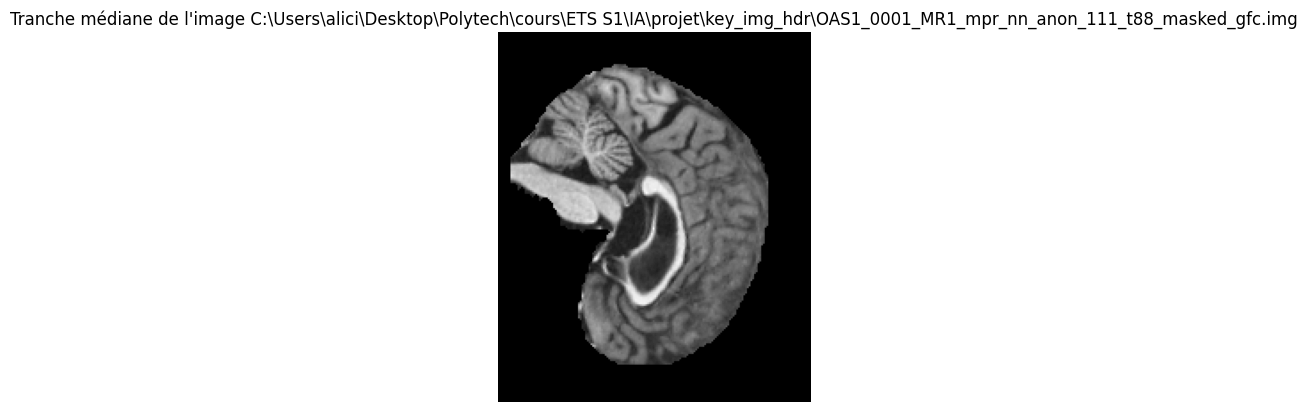

In [9]:
# Paramètres principaux
key_folder = r"C:\Users\alici\Desktop\Polytech\cours\ETS S1\IA\projet\key_img_hdr"
#BIEN PENSER A CHANGER LE CHEMIN D'ACCES DES FICHIERS .HDR, .KEY ET .IMG (NOUS ILS SONT DANS LE MEME DOSSIER "key_img_hdr")

target_shape = (176, 208, 352)  # Taille cible pour le volume reconstruit

# Parcourir le dossier pour charger les points clés et les images associées
database_keypoints = []
database_imgs = []

print("Chargement des points clés et des images associées...")
for file in os.listdir(key_folder):
    if file.endswith(".key"):  # Charger uniquement les fichiers .key
        try:
            key_file_path = os.path.join(key_folder, file)
            hdr_file_path = key_file_path.replace(".key", ".hdr")  # Chemin vers le fichier .hdr
            img_file_path = key_file_path.replace(".key", ".img")  # Chemin vers le fichier .img
            
            if os.path.exists(hdr_file_path) and os.path.exists(img_file_path):
                # Charger les points clés et ajouter l'image associée
                keypoints = load_keypoints(key_file_path)
                database_keypoints.append(keypoints)  # Ajouter les points clés du fichier actuel
                database_imgs.extend([img_file_path] * len(keypoints))  # Associer chaque point clé à l'image
            else:
                print(f"Image ou fichier HDR associé manquant pour {key_file_path}")
        except Exception as e:
            print(f"Erreur lors du traitement de {file}: {e}")

# Fusionner les points clés en une seule base
if database_keypoints:
    database_keypoints = np.vstack(database_keypoints)  # Combine les listes en une seule array
else:
    raise ValueError("Aucun point clé valide trouvé dans le dossier.")

# Affichage des points clés pour vérification
print("Points clés extraits :")
print(database_keypoints)

# Vérifiez les dimensions des points clés
print(f"Nombre total de points clés : {len(database_keypoints)}")
print(f"Dimensions des points clés : {database_keypoints.shape}")

# Exemple d'affichage d'une image (pour vérifier le chargement)
img_path_example = database_imgs[0]  # Choisir une image parmi celles chargées
hdr_file_example = img_path_example.replace('.img', '.hdr')  # Le fichier .hdr correspondant

# Charger l'image à partir des fichiers .hdr et .img
img_example = load_hdr_img(hdr_file_example, img_path_example)

# Affichage de l'image 3D dans la tranche médiane (pour visualiser)
mid_slice = img_example[img_example.shape[0] // 2, :, :]
plt.imshow(mid_slice, cmap='gray')
plt.title(f"Tranche médiane de l'image {img_path_example}")
plt.axis('off')
plt.show()

In [10]:
# Charger les points clés d'un fichier spécifique
input_key_file = r"C:\Users\alici\Desktop\Polytech\cours\ETS S1\IA\projet\point_cle_test\OAS1_0454_MR1_mpr_nn_anon_111_t88_masked_gfc.key"
#BIEN PENSER A CHANGER LE CHEMIN D'ACCES DES FICHIERS .KEY (NOUS ILS SONT DANS LE MEME DOSSIER "key_img_hdr")

input_keypoints = load_keypoints(input_key_file)
print("Points clés de l'entrée chargés à partir de", input_key_file)

Points clés de l'entrée chargés à partir de C:\Users\alici\Desktop\Polytech\cours\ETS S1\IA\projet\point_cle_test\OAS1_0454_MR1_mpr_nn_anon_111_t88_masked_gfc.key


https://www.ibm.com/fr-fr/topics/knn
https://openaccess.thecvf.com/content/CVPR2022/papers/Lee_KNN_Local_Attention_for_Image_Restoration_CVPR_2022_paper.pdf

In [11]:
# Reconstruction du volume
print("Début de la reconstruction...")
reconstructed_volume, saved_patches = knn_local_reconstruction_dynamic_patch(
    input_keypoints,
    database_keypoints,
    database_imgs,
    k=3,
    padding=10,
    target_shape=(176, 208, 176)
)

Début de la reconstruction...
Erreur lors du traitement du voisin 134592: operands could not be broadcast together with shapes (21,21,21) (21,20,20) (21,21,21) 
Erreur lors du traitement du voisin 138911: operands could not be broadcast together with shapes (21,21,20) (20,20,20) (21,21,20) 
Erreur lors du traitement du voisin 330150: operands could not be broadcast together with shapes (18,18,18) (18,17,18) (18,18,18) 
Erreur lors du traitement du voisin 279900: operands could not be broadcast together with shapes (18,18,18) (18,18,17) (18,18,18) 
Erreur lors du traitement du voisin 222725: operands could not be broadcast together with shapes (25,26,25) (25,25,25) (25,26,25) 
Erreur lors du traitement du voisin 80329: operands could not be broadcast together with shapes (26,26,25) (25,26,25) (26,26,25) 
Erreur lors du traitement du voisin 333968: operands could not be broadcast together with shapes (26,26,25) (25,25,25) (26,26,25) 
Erreur lors du traitement du voisin 41311: operands co

In [12]:
print("Min:", np.min(reconstructed_volume))
print("Max:", np.max(reconstructed_volume))
print("Mean:", np.mean(reconstructed_volume))


Min: 0.0
Max: 2766.211981274615
Mean: 222.05787645702054


In [13]:
# Inspecter un patch sauvegardé
#if saved_patches:
   # sample_patch = saved_patches[0]
   # print("Input Point:", sample_patch["input_point"])
   # print("Source Point:", sample_patch["source_point"])
    ##print("Dynamic Patch Size:", sample_patch["dynamic_patch_size"])
    #print("Source Slices:", sample_patch["source_slices"])
   # print("Target Slices:", sample_patch["target_slices"])
#
    # Visualiser le patch
   # plt.imshow(sample_patch["patch"][0], cmap="gray")  # Première coupe du patch
   # plt.title("Patch sauvegardé (coupe)")
    #plt.show()


In [14]:
def reorient_volume(volume):
    """
    Réoriente un volume 3D pour aligner correctement les axes.
    Args:
        volume (numpy.ndarray): Volume 3D initial.
    Returns:
        numpy.ndarray: Volume correctement réorienté.
    """
    # Étape 1 : Rotation pour aligner le plan axial
    rotated_volume = np.rot90(volume, k=1, axes=(0, 2))  # Rotation dans le plan (Z, X)

    # Étape 2 : Inversion pour corriger haut/bas
    flipped_volume = np.flip(rotated_volume, axis=0)  # Inversion sur l'axe X (avant/arrière)
    flipped_volume = np.flip(flipped_volume, axis=2)  # Inversion sur l'axe X (avant/arrière)
    return flipped_volume


In [15]:
# Normalisation, réorientation et sauvegarde du volume
print("Début de la normalisation, réorientation et sauvegarde...")
reconstructed_volume = normalize_volume(reconstructed_volume)
volume_corrige = reorient_volume(reconstructed_volume)
output_prefix = r"C:\Users\alici\Desktop\Polytech\cours\ETS S1\IA\projet\reconstructed_volume_454_k3"
#BIEN PENSER A CHANGER LE CHEMIN D'ACCES POUR LA RECONSTRUCTION


save_volume_as_img_and_mhd(volume_corrige, output_prefix, spacing=(1.0, 1.0, 1.0))
print("Normalisation et sauvegarde terminées.")

Début de la normalisation, réorientation et sauvegarde...
Normalisation et sauvegarde terminées.


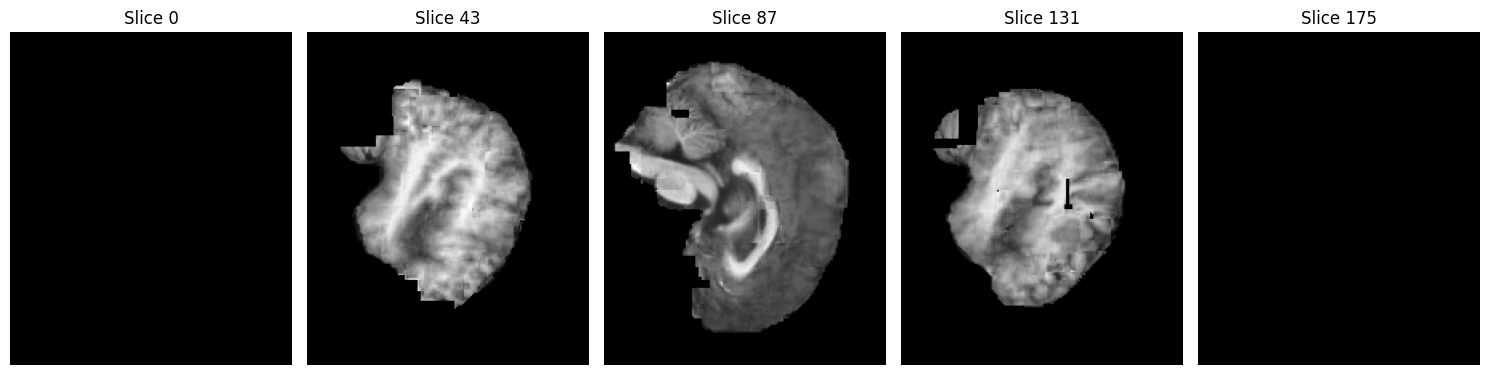

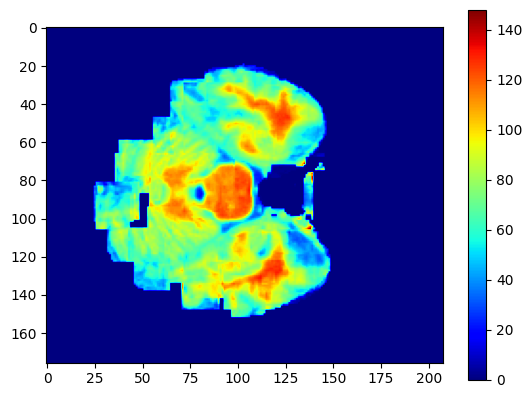

In [16]:
# Visualisation du volume reconstruit
#print("Affichage des coupes du volume reconstruit...")
visualize_slices(reconstructed_volume)
#print("Volume reconstruit sauvegardé et prêt à être visualisé dans 3D Slicer.")

plt.imshow(reconstructed_volume[:, :, 50], cmap='jet')  # Exemple pour la coupe 50
plt.colorbar()
plt.show()
